# Import Libraries 

In [ ]:
#import the necessary files and libraries 
#import the necessary libraries 
!pip install tweet-preprocessor
!pip install symspellpy
!pip install tqdm
!pip install zeugma
from zeugma.embeddings import EmbeddingTransformer
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import TweetTokenizer
from symspellpy.symspellpy import SymSpell
from bs4 import BeautifulSoup
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import preprocessor as p
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lxml
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow as tf 
import io
import re
import string
import nltk
import pkg_resources
import ast 
import pickle
import gensim
import logging
import nltk.data
nltk.download('punkt')
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')

     |████████████████████████████████| 2.6MB 8.4MB/s 
  Created wheel for zeugma: filename=zeugma-0.48-cp36-none-any.whl size=8777 sha256=4dd50808ea33b8628bd27453c62f0c8139defc1874fcccb2ff60eba6a8135395
  Stored in directory: /root/.cache/pip/wheels/6a/b5/bc/5183ac478b0071d04d3ed0c0dd4a43db94c5c8ffb317b5eb53
Successfully built zeugma
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


KeyboardInterrupt: ignored

# Data Cleaning

## Load the DataFrames

In [ ]:
#read the files into their respective dataframes 
labela_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/labels-levela.csv', header = None)
labelb_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/labels-levelb.csv', header = None)
labelc_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/labels-levelc.csv', header = None)
testa_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/testset-levela.tsv', sep = '\t')
testb_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/testset-levelb.tsv', sep = '\t')
testc_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/testset-levelc.tsv', sep = '\t')
train_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/olid-training-v1.0.tsv', sep = '\t')
experiment_df = pd.read_excel('/content/drive/My Drive/CDS_Project/OLIDv1/Data/PublicData.xlsx')



KeyboardInterrupt: ignored

In [ ]:
#Clean the experimental labels 
experiment_df['subtask_a'] = experiment_df['subtask_a'].replace('OFF ', 'OFF')
experiment_df['subtask_b'] = experiment_df['subtask_b'].replace('OFF ', 'OFF')
experiment_df['subtask_c'] = experiment_df['subtask_c'].replace('OFF ', 'OFF')
experiment_df['subtask_a'].unique(),experiment_df['subtask_b'].unique(), experiment_df['subtask_c'].unique() 

(array(['OFF', 'NOT'], dtype=object),
 array(['TIN', nan, 'UNT'], dtype=object),
 array(['IND', 'GRP', 'OTH', nan], dtype=object))

In [ ]:
#Split the experiment data into A, B and C
experiment_a_df = experiment_df[['tweet', 'subtask_a']]
experiment_b_df = experiment_df[['tweet', 'subtask_b']]
experiment_c_df = experiment_df[['tweet', 'subtask_c']]
experiment_a_df.head()

,tweet,subtask_a
0,RT @iSellGreenCards: 1st RT @MsSashaBelle: Sho...,OFF
1,@40oz_VAN IYCMI. I can't get any work done if ...,OFF
2,&#8220;@lildebo2391: He too rich to let that b...,OFF
3,Really Barnicle? OJ or Anthony Weiner? MJ is a...,OFF
4,RT @GabrielaAngela4: That hoe wanta 6/6.,OFF


In [ ]:
#Merge the label dataset with the test data set, so only Test data set needed

testa_df['subtask_a'] = labela_df[1]
testb_df['subtask_b'] = labelb_df[1]
testc_df['subtask_c'] = labelc_df[1]
testc_df.head()

,id,tweet,subtask_c,clean_tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OTH,"[democrat, support, ant, muslim, brotherhood, ..."
1,60133,#NoPasaran: Unity demo to oppose the far-right...,GRP,"[unity, demo, oppose, far, right, enough, enough]"
2,83681,. . . What the fuck did he do this time?,IND,"[fuck, he, time]"
3,65507,@USER Do you get the feeling he is kissing @US...,OTH,"[you, get, feeling, he, kissing, behind, he, h..."
4,34263,#StopKavanaugh he is liar like the rest of the...,IND,"[he, liar, like, rest]"


In [ ]:
#View the training data set
train_df.head()

,id,tweet,subtask_a,subtask_b,subtask_c,clean_tweet,clean_tweet_str
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,"[she, ask, native, american, take]",she ask native american take
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,"[go, home, you, drunk]",go home you drunk
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,"[amazon, investigating, chinese, employee, sel...",amazon investigating chinese employee selling ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,"[someone, vet, ken, piece, shit, volcano]",someone vet ken piece shit volcano
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,"[obama, wanted, liberal, amp, illegals, move, ...",obama wanted liberal amp illegals move red state


## Cleaning the Tweets

The training and test data are in 2 separate files, so a function has been written to to tidy the text up and return a column of cleaned tweets

* remove URLs, Hashtags, Mentions, Reserved Words (RT, FAV), Emojis
* Change text to lowercase 
* Handle Apostrophe (e.g. aren't -> are not)
* Remove punctuations
* Remove numbers 
* Segment the words (fix the spelling) 
* Lemmatization and Tokenization
* Remove Stop Words (with Blacklist and Whitelist words)

### Cleaning Function

In [ ]:
#list of contractions to remove later 
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
#Setting up SymSpell to segment words
sym_spell = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
# term_index is the column of the term and count_index is the column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)


True

In [ ]:
#Setting up Lematizer, Tokenizer
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = TweetTokenizer()

In [ ]:
#Removes specially chosen stop words
def cleaner(row, contractions, blacklist, whitelist):
  '''
  Blacklist: Words that are not in stop words but we will be removing 
  Whitelist: Words that are in the stop words but we will be keeping
  '''
  #remove URLs, Hashtags, Mentions, Reserved Words (RT, FAV), Emojis
  row = p.clean(row)
  #lower the text 
  row = row.lower()
  #Apostrophe Handling
  for word in row.split():
    if word in contractions: 
      row = row.replace(word, contractions[word.lower()])
  #remove punctuations
  row  = "".join([char for char in row if char not in string.punctuation])
  row = re.sub('[0-9]+', '', row, flags=re.MULTILINE)
  #remove numbers 
  row = re.sub(r'\d+', '', row, flags=re.MULTILINE)
  #Segment the words 
  try:
    row = (sym_spell.word_segmentation(row)).corrected_string
  except: 
    pass
  #Lemmatization and Tokenization
  row = [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((row))]
  #Stopwords 
  all_stopwords = stopwords.words('english')
  all_stopwords.extend(blacklist)
  all_stopwords = set(all_stopwords)- set(whitelist)
  row = [word for word in row if word not in all_stopwords]
  return row

In [ ]:
tqdm.pandas()
#List of stopwords that want to remove in addition to the ones in stopwords corpus
badboy_list = ['url', 'ha']
#List of stopwords that we would like to keep 
goodboy_list = ['i', 'he', 'she', 'it', 'him', 'her', 'we', 'you', 'they', 'us', 'them' ]
#Apply modified clean tweet to the training data
train_df['clean_tweet'] = train_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
#Apply modified clean tweet to the test data
testc_df['clean_tweet'] = testc_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
testb_df['clean_tweet'] = testb_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
testa_df['clean_tweet'] = testa_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
#Apply modified cleaen tweet to the experimental data 
experiment_a_df['clean_tweet'] = experiment_a_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
experiment_b_df['clean_tweet'] = experiment_b_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))
experiment_c_df['clean_tweet'] = experiment_c_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))

100%|██████████| 102/102 [00:00<00:00, 184.11it/s]


In [ ]:
#Train Dataframe for each of the subsets  
train_df_a = train_df.dropna(subset=['subtask_a'])
train_df_a = train_df_a.drop(columns = ['subtask_b', 'subtask_c'])
train_df_b = train_df.dropna(subset=['subtask_b'])
train_df_b = train_df_b.drop(columns = ['subtask_a', 'subtask_c'])
train_df_c = train_df.dropna(subset=['subtask_c'])
train_df_c = train_df_c.drop(columns = ['subtask_a', 'subtask_b'])
experiment_a_df = experiment_a_df.dropna(subset=['subtask_a']) 
experiment_b_df = experiment_b_df.dropna(subset=['subtask_b'])
experiment_c_df = experiment_c_df.dropna(subset=['subtask_c'])

In [ ]:
experiment_a_df['subtask_a'].unique(), experiment_b_df['subtask_b'].unique(), experiment_c_df['subtask_c'].unique()

(array(['OFF', 'NOT'], dtype=object),
 array(['TIN', 'UNT'], dtype=object),
 array(['IND', 'GRP', 'OTH'], dtype=object))

Key Dataframes 

In [ ]:
#Split the data into X and Y 
#Split the data into X and Y
a_trainX_df = train_df_a['clean_tweet']
a_trainY_df = train_df_a['subtask_a'] 
a_testX_df = testa_df['clean_tweet'] 
a_testY_df = testa_df['subtask_a'] 
a_experimentX_df = experiment_a_df['clean_tweet']
a_experimentY_df = experiment_a_df['subtask_a']

b_trainX_df = train_df_b['clean_tweet']
b_trainY_df = train_df_b['subtask_b'] 
b_testX_df = testb_df['clean_tweet'] 
b_testY_df = testb_df['subtask_b'] 
b_experimentX_df = experiment_b_df['clean_tweet']
b_experimentY_df = experiment_b_df['subtask_b']


c_trainX_df = train_df_c['clean_tweet']
c_trainY_df = train_df_c['subtask_c'] 
c_testX_df = testc_df['clean_tweet'] 
c_testY_df = testc_df['subtask_c'] 
c_experimentX_df = experiment_c_df['clean_tweet']
c_experimentY_df = experiment_c_df['subtask_c']

## Vectorizing the Tweets

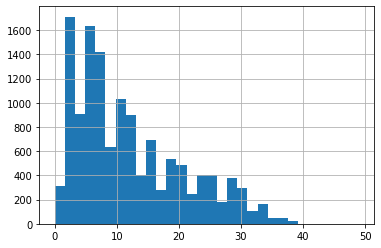

In [ ]:
#Convert list to string
train_df['clean_tweet_str'] = train_df['clean_tweet'].apply(lambda x: ' '.join([str(elem) for elem in x]))

# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_df['clean_tweet_str']]
pd.Series(seq_len).hist(bins = 30)



In [ ]:
#Count the number of unique words
from collections import Counter
results = Counter()
train_df['clean_tweet_str'].str.lower().str.split().apply(results.update)
print(len(results.keys()))

13828


In [ ]:
#Vectorizing the training data
#https://stackoverflow.com/questions/45735070/keras-text-preprocessing-saword_ving-tokenizer-object-to-file-for-scoring
def vectorizing(trainX_df, testX_df, experiment_dfX, category):
  MAX_NUM_WORDS = 13828 # Parameter indicating the number of words we'll put in the dictionary
  MAX_SEQUENCE_LENGTH = 40 # Maximum number of words in a sequence
  tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
  tokenizer.fit_on_texts(trainX_df)
  token_file_name = 'tokenizer_' + category + '.pickle'
  with open(token_file_name, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  #Tokenize the training and test data set
  trainX_seq = tokenizer.texts_to_sequences(trainX_df)
  testX_seq = tokenizer.texts_to_sequences(testX_df)
  experimentX_seq = tokenizer.texts_to_sequences(experiment_dfX)

  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  #Padding the sequence 
  trainX_seq_trunc = pad_sequences(trainX_seq, maxlen=MAX_SEQUENCE_LENGTH)
  testX_seq_trunc = pad_sequences(testX_seq, maxlen=MAX_SEQUENCE_LENGTH)
  experimentX_seq_trunc = pad_sequences(experimentX_seq, maxlen = MAX_SEQUENCE_LENGTH)
  return trainX_seq_trunc, testX_seq_trunc, experimentX_seq_trunc, word_index

In [ ]:
a_trainX_df.head()

0                   [she, ask, native, american, take]
1                               [go, home, you, drunk]
2    [amazon, investigating, chinese, employee, sel...
3            [someone, vet, ken, piece, shit, volcano]
4    [obama, wanted, liberal, amp, illegals, move, ...
Name: clean_tweet, dtype: object

In [ ]:
#Generate vectorized matrix for A B and C
vec_a_trainX_df, vec_a_testX_df, vec_a_exp_df, word_index_a = vectorizing(a_trainX_df, a_testX_df, a_experimentX_df, 'a')
vec_b_trainX_df, vec_b_testX_df, vec_b_exp_df, word_index_b = vectorizing(b_trainX_df, b_testX_df, b_experimentX_df,'b')
vec_c_trainX_df, vec_c_testX_df, vec_c_exp_df, word_index_c = vectorizing(c_trainX_df, c_testX_df, c_experimentX_df, 'c')

Found 13828 unique tokens.
Found 8208 unique tokens.
Found 7751 unique tokens.


In [ ]:
a_experimentY_df.unique()

array(['OFF', 'NOT'], dtype=object)

In [ ]:
#Convert the target classes to categoricial  
le = LabelEncoder()
ie_a_trainY_df = le.fit_transform(a_trainY_df)
print(le.classes_)
ie_a_testY_df = le.transform(a_testY_df)
ie_a_exp_y_df = le.transform(a_experimentY_df)
ie_b_trainY_df = le.fit_transform(b_trainY_df)
print(le.classes_)
ie_b_testY_df = le.transform(b_testY_df)
ie_b_exp_y_df = le.transform(b_experimentY_df)
ie_c_trainY_df = le.fit_transform(c_trainY_df)
print(le.classes_)
ie_c_testY_df = le.transform(c_testY_df)
ie_c_exp_y_df = le.transform(c_experimentY_df)

#Convert to One Hot Encoding
oh_a_trainY_df = to_categorical(ie_a_trainY_df)
oh_a_testY_df = to_categorical(ie_a_testY_df)
oh_a_exp_y_df = to_categorical(ie_a_exp_y_df)
oh_b_trainY_df = to_categorical(ie_b_trainY_df)
oh_b_testY_df = to_categorical(ie_b_testY_df)
oh_b_exp_y_df = to_categorical(ie_b_exp_y_df)
oh_c_trainY_df = to_categorical(ie_c_trainY_df)
oh_c_testY_df = to_categorical(ie_c_testY_df)
oh_c_exp_y_df = to_categorical(ie_c_exp_y_df)

['NOT' 'OFF']
['TIN' 'UNT']
['GRP' 'IND' 'OTH']


In [ ]:
le.classes_

array(['GRP', 'IND', 'OTH'], dtype=object)

In [ ]:
oh_a_trainY_df.shape,ie_a_trainY_df.shape

((13240, 2), (13240,))

### Splitting of Validation Data
* For one hot encoding
* For integer encoding

In [ ]:
#Allocate 10% of the training data for validation 
oh_a_trainX_df, oh_a_validX_df, oh_a_trainY_df, oh_a_validY_df = train_test_split(vec_a_trainX_df, oh_a_trainY_df, test_size = 0.1, random_state = 37)
oh_b_trainX_df, oh_b_validX_df, oh_b_trainY_df, oh_b_validY_df = train_test_split(vec_b_trainX_df, oh_b_trainY_df, test_size = 0.1, random_state = 37)
oh_c_trainX_df, oh_c_validX_df, oh_c_trainY_df, oh_c_validY_df = train_test_split(vec_c_trainX_df, oh_c_trainY_df, test_size = 0.1, random_state = 37)

#For Integer Encoding 
le_a_trainX_df, le_a_validX_df, le_a_trainY_df, le_a_validY_df = train_test_split(vec_a_trainX_df, ie_a_trainY_df, test_size = 0.1, random_state = 37)
le_b_trainX_df, le_b_validX_df, le_b_trainY_df, le_b_validY_df = train_test_split(vec_b_trainX_df, ie_b_trainY_df, test_size = 0.1, random_state = 37)
le_c_trainX_df, le_c_validX_df, le_c_trainY_df, le_c_validY_df = train_test_split(vec_c_trainX_df, ie_c_trainY_df, test_size = 0.1, random_state = 37)

In [ ]:
le_a_trainX_df

array([[   0,    0,    0, ..., 3382, 4711,  286],
       [   0,    0,    0, ...,   68,  130, 4400],
       [   0,    0,    0, ...,   37, 1965,  826],
       ...,
       [   0,    0,    0, ...,  971,   24,    3],
       [   0,    0,    0, ..., 4466, 3463,   43],
       [   0,    0,    0, ...,    0,   77, 3143]], dtype=int32)

###After obtaining cleaned tweets, One Hot, Integer Encoding for subtask A,B,C,
###we want to carry out a baseline evaluation in choosing an appropriate text vectorisation method. 

###We will be using applying TF-IDF, W2V, GloVe on subtask A, followed by an ###evaluation of results using baseline statistical models.

# TF-IDF

In [ ]:
bdef identity_tokenizer(text):
    return text

#tfidf transformer
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words=None ,ngram_range=(1,3), lowercase=False, max_features = 5000)    

#transformer will take in cleaned list of tweets from subtask A

X = train_df.iloc[:,5]
y = train_df.iloc[:,2]

X_tfidf = tfidf.fit_transform(X).toarray()

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size = 0.1,
                                                        random_state = 37)


In [ ]:
train_df.iloc[:,5]

0                       [she, ask, native, american, take]
1                                   [go, home, you, drunk]
2        [amazon, investigating, chinese, employee, sel...
3                [someone, vet, ken, piece, shit, volcano]
4        [obama, wanted, liberal, amp, illegals, move, ...
                               ...                        
13235    [sometimes, i, get, strong, vibe, people, man,...
13236      [beni, dorm, cream, field, mag, shabby, summer]
13237                    [report, garbage, we, give, crap]
13238                                              [pussy]
13239                                                  [v]
Name: clean_tweet, Length: 13240, dtype: object

In [ ]:
#Train Dataframe for each of the subsets  
train_tfidf_a = train_df.dropna(subset=['subtask_a'])
train_tfidf_a = train_tfidf_a.drop(columns = ['subtask_b', 'subtask_c'])
train_tfidf_b = train_df.dropna(subset=['subtask_b'])
train_tfidf_b = train_tfidf_b.drop(columns = ['subtask_a', 'subtask_c'])
#train_tfidf_b.head()
train_tfidf_c = train_df.dropna(subset=['subtask_c'])
train_tfidf_c = train_tfidf_c.drop(columns = ['subtask_a', 'subtask_b'])
train_tfidf_c.head()

,id,tweet,subtask_c,clean_tweet,clean_tweet_str
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,IND,"[go, home, you, drunk]",go home you drunk
5,97670,@USER Liberals are all Kookoo !!!,OTH,"[liberal, kook, oo]",liberal kook oo
7,52415,@USER was literally just talking about this lo...,GRP,"[wa, literally, talking, lol, mass, shooting, ...",wa literally talking lol mass shooting like se...
9,13384,@USER Canada doesn’t need another CUCK! We alr...,IND,"[canada, doe, nt, need, another, cuck, we, alr...",canada doe nt need another cuck we already eno...
12,28414,@USER you are a lying corrupt traitor!!! Nobod...,IND,"[you, lying, corrupt, traitor, nobody, want, h...",you lying corrupt traitor nobody want hear any...


In [ ]:
#Split the data into X and Y 
#Split the data into X and Y
a_trainX_tfidf = train_tfidf_a['clean_tweet']
a_trainY_tfidf = train_tfidf_a['subtask_a'] 
#a_testX_tfidf = testa_df['clean_tweet_str'] 
#a_testY_tfidf = testa_df['subtask_a'] 

b_trainX_tfidf = train_tfidf_b['clean_tweet']
b_trainY_tfidf = train_tfidf_b['subtask_b'] 
#b_testX_tfidf = testb_df['clean_tweet_str'] 
#b_testY_tfidf = testb_df['subtask_b'] 


c_trainX_tfidf = train_tfidf_c['clean_tweet']
c_trainY_tfidf = train_tfidf_c['subtask_c'] 
#c_testX_tfidf = testc_df['clean_tweet_str'] 
#c_testY_tfidf = testc_df['subtask_c'] 

In [ ]:
a_trainX_tfidf

0                       [she, ask, native, american, take]
1                                   [go, home, you, drunk]
2        [amazon, investigating, chinese, employee, sel...
3                [someone, vet, ken, piece, shit, volcano]
4        [obama, wanted, liberal, amp, illegals, move, ...
                               ...                        
13235    [sometimes, i, get, strong, vibe, people, man,...
13236      [beni, dorm, cream, field, mag, shabby, summer]
13237                    [report, garbage, we, give, crap]
13238                                              [pussy]
13239                                                  [v]
Name: clean_tweet, Length: 13240, dtype: object

In [ ]:
# Data for a
X_tfidf_a = tfidf.fit_transform(a_trainX_tfidf).toarray()

X_train_tfidf_a, X_val_tfidf_a, y_train_tfidf_a, y_val_tfidf_a = train_test_split(X_tfidf_a, a_trainY_tfidf, test_size = 0.1,
                                                        random_state = 37)
# Data for b
X_tfidf_b = tfidf.fit_transform(b_trainX_tfidf).toarray()

X_train_tfidf_b, X_val_tfidf_b, y_train_tfidf_b, y_val_tfidf_b = train_test_split(X_tfidf_b, b_trainY_tfidf, test_size = 0.1,
                                                        random_state = 37)
# Data for c
X_tfidf_c = tfidf.fit_transform(c_trainX_tfidf).toarray()

X_train_tfidf_c, X_val_tfidf_c, y_train_tfidf_c, y_val_tfidf_c = train_test_split(X_tfidf_c, c_trainY_tfidf, test_size = 0.1,
                                                        random_state = 37)

#Word2Vec

In [ ]:
!wget -P ./ "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-12-08 08:02:04--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.96.45
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.96.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘./GoogleNews-vectors-negative300.bin.gz.1’

GoogleNews-vectors- 100%[===================>]   1.53G  15.8MB/s    in 2m 12s  

2020-12-08 08:04:17 (11.9 MB/s) - ‘./GoogleNews-vectors-negative300.bin.gz.1’ saved [1647046227/1647046227]



In [ ]:
from gensim.models import Word2Vec

w2v = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", 
                                                     binary=True)
w2v.init_sims(replace=True)
print('Model loaded')

TypeError: ignored

As we have multiple words for each post, we want to combine them. We will average the word vectors per document using the function below.



In [ ]:
def word_averaging(wv, words):
    # averages a set of words 'words' given their wordvectors 'wv'
    
    all_words, mean = set(), []
    
    # for each word in the list of words
    for word in words:
      if isinstance(word, np.ndarray):
        mean.append(word)
  # if not: first get the vector embedding for the words      
      elif word in wv.vocab:
          mean.append(wv.syn0norm[wv.vocab[word].index])
          all_words.add(wv.vocab[word].index)

    if not mean:
        # error handling in case mean cannot be calculated
        logging.warning("cannot compute similarity with no input %s", words)
        return np.zeros(wv.vector_size,)

    # use gensim's method to calculate the mean of all the words appended to mean list
    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [ ]:
X_string = train_df.iloc[:,6]

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_string, y, test_size = 0.1,
                                                        random_state = 37)


In [ ]:
word_averaging_list(w2v, X_train_w2v)
#X_train_w2v.count

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


array([[-0.09960043,  0.065391  , -0.0147709 , ..., -0.0158936 ,
        -0.06606388,  0.08280224],
       [-0.09857686,  0.06318619,  0.00730469, ..., -0.02053084,
        -0.06356247,  0.09426809],
       [-0.11192186,  0.07825133, -0.00218853, ..., -0.02330061,
        -0.06794364,  0.0895485 ],
       ...,
       [-0.10193821,  0.05938056, -0.00520735, ..., -0.01875439,
        -0.07204743,  0.07795371],
       [-0.09595536,  0.05227422, -0.01478258, ..., -0.0201808 ,
        -0.08201713,  0.0762513 ],
       [-0.12171841,  0.04620853,  0.00539464, ..., -0.02795007,
        -0.08189067,  0.09044704]])

In [ ]:
test = word_averaging_list(w2v, X_train_w2v_a)
len(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


11916

In [ ]:
test = word_averaging_list(w2v, X_train_w2v)
len(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


11916

In [ ]:
train_word_average = word_averaging_list(w2v, X_train_w2v)
test_word_average = word_averaging_list(w2v, X_test_w2v)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
#Split the data into X and Y
a_trainX_w2v = train_tfidf_a['clean_tweet_str']
a_trainY_w2v = train_tfidf_a['subtask_a'] 
#a_testX_tfidf = testa_df['clean_tweet_str'] 
#a_testY_tfidf = testa_df['subtask_a'] 

b_trainX_w2v = train_tfidf_b['clean_tweet_str']
b_trainY_w2v = train_tfidf_b['subtask_b'] 
#b_testX_tfidf = testb_df['clean_tweet_str'] 
#b_testY_tfidf = testb_df['subtask_b'] 


c_trainX_w2v = train_tfidf_c['clean_tweet_str']
c_trainY_w2v = train_tfidf_c['subtask_c'] 
#c_testX_tfidf = testc_df['clean_tweet_str'] 
#c_testY_tfidf = testc_df['subtask_c'] 

In [ ]:
## A
X_train_w2v_a, X_val_w2v_a, y_train_w2v_a, y_val_w2v_a = train_test_split(a_trainX_w2v, a_trainY_w2v, test_size = 0.1,
                                                        random_state = 37)
train_word_average_a = word_averaging_list(w2v, X_train_w2v_a)
test_word_average_a = word_averaging_list(w2v, X_val_w2v_a)

# ## B
# X_train_w2v_b, X_val_w2v_b, y_train_w2v_b, y_val_w2v_b = train_test_split(b_trainX_w2v, b_trainY_w2v, test_size = 0.1,
#                                                         random_state = 37)
# train_word_average_b = word_averaging_list(w2v, X_train_w2v_b)
# test_word_average_b = word_averaging_list(w2v, X_val_w2v_b)

# ## C
# X_train_w2v_c, X_val_w2v_c, y_train_w2v_c, y_val_w2v_c = train_test_split(c_trainX_w2v, c_trainY_w2v, test_size = 0.1,
#                                                         random_state = 37)
# train_word_average_a = word_averaging_list(w2v, X_train_w2v_c)
# test_word_average_a = word_averaging_list(w2v, X_val_w2v_c)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
len(train_word_average_a)

3488

# GloVe
* For Neural Network 
* For statistical model

## For Neural Network

In [ ]:
# #Export the relevant matrices to the folder
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/X_train_a.csv", le_a_trainX_df, delimiter=",") 
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/X_valid_a.csv", le_a_validX_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/y_train_a.csv", le_a_trainY_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/y_valid_a.csv", le_a_validY_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/X_test_a.csv", vec_a_testX_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/y_test_a.csv", ie_a_testY_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/X_exp_a.csv", vec_a_exp_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/y_exp_a.csv", ie_a_exp_y_df, delimiter=",")

np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/X_train_b.csv", le_b_trainX_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/X_valid_b.csv", le_b_validX_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/y_train_b.csv", le_b_trainY_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/y_valid_b.csv", le_b_validY_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/X_test_b.csv", vec_b_testX_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/y_test_b.csv", ie_b_testY_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/X_exp_b.csv", vec_b_exp_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/y_exp_b.csv", ie_b_exp_y_df, delimiter=",")

np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/X_train_c.csv", le_c_trainX_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/X_valid_c.csv", le_c_validX_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/y_train_c.csv", le_c_trainY_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/y_valid_c.csv", le_c_validY_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/X_test_c.csv", vec_c_testX_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/y_test_c.csv", ie_c_testY_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/X_exp_c.csv", vec_c_exp_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/y_exp_c.csv", ie_c_exp_y_df, delimiter=",")

In [ ]:
le_b_trainX_df.shape, le_b_trainY_df.shape, le_b_validX_df.shape, le_b_validY_df.shape, vec_b_testX_df.shape, ie_b_testY_df.shape

((3960, 40), (3960,), (440, 40), (440,), (240, 40), (240,))

In [ ]:
#compute an index mapping words to known embeddings, by parsing the data dump of pre-trained embeddings:
embeddings_index = {}
glove_data = open('/content/drive/My Drive/CDS_Project/OLIDv1/glove.twitter.27B.200d.txt')
for line in glove_data:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
glove_data.close()

EMBEDDING_DIM = 200
print('Found %s word vectors.' % len(embeddings_index))

FileNotFoundError: ignored

In [ ]:
#leverage on embedding_index dictionary and our word_index to compute embedding matrix
def em_matrix(word_index, EMBEDDING_DIM, embeddings_index):
  embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))
  for word, i in word_index.items(): #word_index.items e.g. (hello,1)
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
  return embedding_matrix

In [ ]:
#Export the embedded matrix
em_mat_a = em_matrix(word_index_a, 200, embeddings_index)
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/glove_embed_a.csv", em_mat_a, delimiter=",")
em_mat_b = em_matrix(word_index_b, 200, embeddings_index)
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/glove_embed_b.csv", em_mat_b, delimiter=",")
em_mat_c = em_matrix(word_index_c, 200, embeddings_index)
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/glove_embed_c.csv", em_mat_c, delimiter=",")

## For STATS Model

In [ ]:
#convert the training data to string
a_trainX_str = a_trainX_df.apply(', '.join)
a_testX_str = a_testX_df.apply(', ' .join)
a_expX_str = a_experimentX_df.apply(',' .join)
b_trainX_str = b_trainX_df.apply(', '.join)
b_testX_str = b_testX_df.apply(', '.join)
b_expX_str = b_experimentX_df.apply(',' .join)
c_trainX_str = c_trainX_df.apply(', '.join)
c_testX_str = c_testX_df.apply(', '.join)
c_expX_str = c_experimentX_df.apply(',' .join)

In [ ]:
#Download the embedding transformer 
## TAKES LONG
glove = EmbeddingTransformer('glove-twitter-200')


[==================================================] 100.0% 758.5/758.5MB downloaded


In [ ]:
#Embed the training data 
a_trainX_em = glove.transform(a_trainX_str)
a_testX_em = glove.transform(a_testX_str)
a_expX_em = glove.transform(a_expX_str)
b_trainX_em = glove.transform(b_trainX_str)
b_testX_em = glove.transform(b_testX_str)
b_expX_em = glove.transform(b_expX_str)
c_trainX_em = glove.transform(c_trainX_str)
c_testX_em = glove.transform(c_testX_str)
c_expX_em = glove.transform(c_expX_str)

In [ ]:
b_trainX_em.shape, ie_b_trainY_df.shape, b_testX_df.shape, b_testX_em.shape

((4400, 200), (4400,), (240,), (240, 200))

In [ ]:
# Create Validation Split
a_trainX_em, a_validX_em, a_trainY_em, a_validY_em = train_test_split(a_trainX_em, ie_a_trainY_df, test_size=0.1, random_state=37)
b_trainX_em, b_validX_em, b_trainY_em, b_validY_em = train_test_split(b_trainX_em, ie_b_trainY_df, test_size=0.1, random_state=37)
c_trainX_em, c_validX_em, c_trainY_em, c_validY_em = train_test_split(c_trainX_em, ie_c_trainY_df, test_size=0.1, random_state=37)

In [ ]:
#Export the relevant matrices to the folder
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/X_train_a.csv", a_trainX_em, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/X_valid_a.csv", a_validX_em, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/y_train_a.csv", le_a_trainY_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/y_valid_a.csv", a_validY_em, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/X_test_a.csv", a_testX_em, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/y_test_a.csv", ie_a_testY_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/X_exp_a.csv", a_expX_em, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/y_exp_a.csv", ie_a_exp_y_df, delimiter=",")

np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/X_train_b.csv", b_trainX_em, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/X_valid_b.csv", b_validX_em, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/y_train_b.csv", le_b_trainY_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/y_valid_b.csv", b_validY_em, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/X_test_b.csv", b_testX_em, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/y_test_b.csv", ie_b_testY_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/X_exp_b.csv", b_expX_em, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/y_exp_b.csv", ie_b_exp_y_df, delimiter=",")

np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/X_train_c.csv", c_trainX_em, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/X_valid_c.csv", c_validX_em, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/y_train_c.csv", le_c_trainY_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/y_valid_c.csv", c_validY_em, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/X_test_c.csv", c_testX_em, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/y_test_c.csv", ie_c_testY_df, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/X_exp_c.csv", c_expX_em, delimiter=",")
np.savetxt("/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/Stats/y_exp_c.csv", ie_c_exp_y_df, delimiter=",")

In [ ]:
a_trainX_em.shape, le_a_trainY_df.shape, b_expX_em.shape, ie_b_exp_y_df.shape

((11916, 200), (11916,), (117, 200), (117,))

# Choosing the Representation 

###We will use logistic regression to evaluate the best vector representation for subtask A and the rest of the project

### Given that the dataset is imbalanced (skewed towards NON offensive tweets), we will be balancing the data when using log regression

### Since spotting an offensive tweet is crucial, we will evaluate the performance using Macro- F1 and Recall Score

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder() 

def evaluate_on_training_set(y_test, y_pred):
  roc_score = roc_auc_score(y_test,y_pred)
# Calculate AUC
  print("AUC is: ", roc_score)
  
# print out recall and precision
  print(classification_report(y_test, y_pred))
  
# print out confusion matrix
  print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

  # # calculate points for ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  
  # Plot ROC curve
  plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
  plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate or (1 - Specifity)')
  plt.ylabel('True Positive Rate or (Sensitivity)')
  plt.title('Receiver Operating Characteristic')

In [ ]:
import sklearn.metrics as metrics
# calculate AUC score by binarizing labels in a one-vs-all fashion
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)

def evaluate_on_training_set_multi(y_test, y_pred, y_pred_prob):
  # roc_auc_score not commonly implemented for multiclass, check confusion matrix instead
  roc_score = multiclass_roc_auc_score(y_test, y_pred)
  # Calculate AUC
  print("AUC is: ", roc_score)

  n_class = 3

  # roc curve for classes
  fpr = {}
  tpr = {}
  thresh ={}

  for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_prob[:,i], pos_label=i)
  
# print out recall and precision
  print(classification_report(y_test, y_pred))
  
# print out confusion matrix
  print("Confusion Matrix: \n", metrics.confusion_matrix(y_test, y_pred))

  # plotting    
  plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
  plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
  plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
  plt.title('Multiclass ROC curve')
  plt.xlabel('False Positive Rate or (1-Specifity)')
  plt.ylabel('True Positive rate or (Sensitivity)')
  plt.legend(loc='best')

## Logistic Regression using TFIDF



Logistic Regression
AUC is:  0.7402200740436036
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       884
           1       0.63      0.68      0.65       440

    accuracy                           0.76      1324
   macro avg       0.73      0.74      0.74      1324
weighted avg       0.77      0.76      0.76      1324

Confusion Matrix: 
 [[710 174]
 [142 298]]


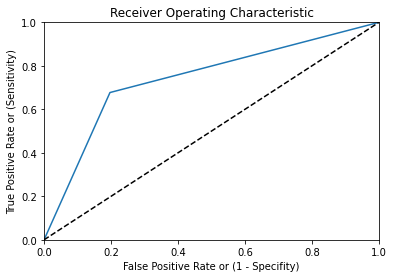

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='lbfgs') 

model.fit(X_train_tfidf, y_train_tfidf) # Training the model

y_pred_tfidf = model.predict(X_test_tfidf)
y_final = lb.fit_transform(y_test_tfidf)
y_pred_tfidf = lb.fit_transform(y_pred_tfidf)

print('\n')
print('Logistic Regression')
evaluate_on_training_set(y_final, y_pred_tfidf)



Logistic Regression
AUC is:  0.7402200740436036
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       884
           1       0.63      0.68      0.65       440

    accuracy                           0.76      1324
   macro avg       0.73      0.74      0.74      1324
weighted avg       0.77      0.76      0.76      1324

Confusion Matrix: 
 [[710 174]
 [142 298]]


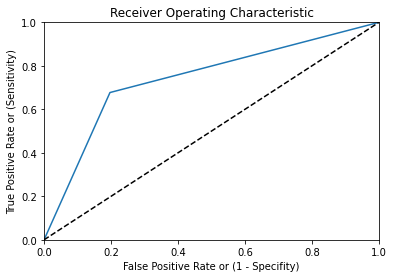

In [ ]:
## A
model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='lbfgs') 

model.fit(X_train_tfidf_a, y_train_tfidf_a) # Training the model

y_pred_tfidf = model.predict(X_val_tfidf_a)
y_final = lb.fit_transform(y_val_tfidf_a)
y_pred_tfidf = lb.fit_transform(y_pred_tfidf)

print('\n')
print('Logistic Regression')
evaluate_on_training_set(y_final, y_pred_tfidf)



Logistic Regression
AUC is:  0.6326918041372087
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       402
           1       0.22      0.39      0.29        38

    accuracy                           0.83       440
   macro avg       0.58      0.63      0.59       440
weighted avg       0.88      0.83      0.85       440

Confusion Matrix: 
 [[350  52]
 [ 23  15]]


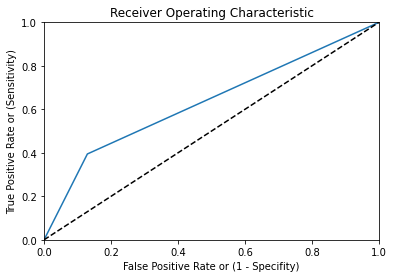

In [ ]:
## B
model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='lbfgs') 

model.fit(X_train_tfidf_b, y_train_tfidf_b) # Training the model

y_pred_tfidf = model.predict(X_val_tfidf_b)
y_final = lb.fit_transform(y_val_tfidf_b)
y_pred_tfidf = lb.fit_transform(y_pred_tfidf)

print('\n')
print('Logistic Regression')
evaluate_on_training_set(y_final, y_pred_tfidf)



Logistic Regression
AUC is:  0.6536031563013297
              precision    recall  f1-score   support

           0       0.48      0.51      0.49        97
           1       0.83      0.76      0.79       261
           2       0.17      0.27      0.21        30

    accuracy                           0.66       388
   macro avg       0.49      0.51      0.50       388
weighted avg       0.69      0.66      0.67       388

Confusion Matrix: 
 [[ 49  29  19]
 [ 42 198  21]
 [ 11  11   8]]


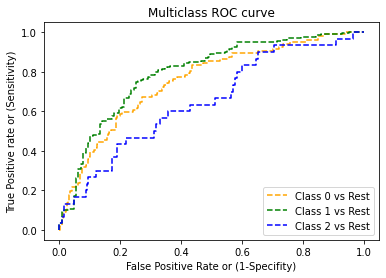

In [ ]:
## C
model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='lbfgs') 

model.fit(X_train_tfidf_c, y_train_tfidf_c) # Training the model

y_pred_tfidf = model.predict(X_val_tfidf_c)
y_final = lb.fit_transform(y_val_tfidf_c)
y_pred_tfidf = lb.fit_transform(y_pred_tfidf)
y_pred_prob = model.predict_proba(X_val_tfidf_c)

print('\n')
print('Logistic Regression')
evaluate_on_training_set_multi(y_final, y_pred_tfidf, y_pred_prob)

## Logistic Regression using Word2Vec

AUC is:  0.5817667626491155
              precision    recall  f1-score   support

           0       0.75      0.52      0.61       884
           1       0.40      0.64      0.49       440

    accuracy                           0.56      1324
   macro avg       0.57      0.58      0.55      1324
weighted avg       0.63      0.56      0.57      1324

Confusion Matrix: 
 [[462 422]
 [158 282]]


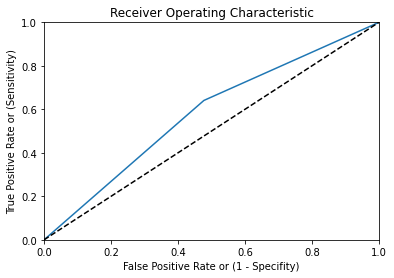

In [ ]:
## A
model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='lbfgs') 
model = model.fit(train_word_average, y_train_w2v)
y_pred = model.predict(test_word_average)

lb = LabelEncoder()
y_pred = lb.fit_transform(y_pred)
y_test_w2v = lb.fit_transform(y_test_w2v)

evaluate_on_training_set(y_test_w2v, y_pred)

In [ ]:
## A
X_train_w2v_a, X_val_w2v_a, y_train_w2v_a, y_val_w2v_a = train_test_split(a_trainX_w2v, a_trainY_w2v, test_size = 0.1,
                                                        random_state = 37)
train_word_average_a = word_averaging_list(w2v, X_train_w2v_a)
test_word_average_a = word_averaging_list(w2v, X_val_w2v_a)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


AUC is:  0.5817667626491155
              precision    recall  f1-score   support

           0       0.75      0.52      0.61       884
           1       0.40      0.64      0.49       440

    accuracy                           0.56      1324
   macro avg       0.57      0.58      0.55      1324
weighted avg       0.63      0.56      0.57      1324

Confusion Matrix: 
 [[462 422]
 [158 282]]


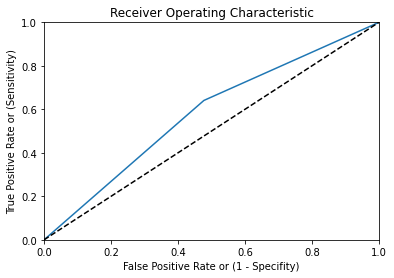

In [ ]:
## A
model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='lbfgs') 
model = model.fit(train_word_average_a, y_train_w2v_a)
y_pred = model.predict(test_word_average_a)

lb = LabelEncoder()
y_pred = lb.fit_transform(y_pred)
y_val_w2v = lb.fit_transform(y_val_w2v_a)

evaluate_on_training_set(y_val_w2v, y_pred)

In [ ]:
## B
X_train_w2v_b, X_val_w2v_b, y_train_w2v_b, y_val_w2v_b = train_test_split(b_trainX_w2v, b_trainY_w2v, test_size = 0.1,
                                                        random_state = 37)
train_word_average_b = word_averaging_list(w2v, X_train_w2v_b)
test_word_average_b = word_averaging_list(w2v, X_val_w2v_b)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


AUC is:  0.6101728201099763
              precision    recall  f1-score   support

           0       0.94      0.69      0.80       402
           1       0.14      0.53      0.22        38

    accuracy                           0.68       440
   macro avg       0.54      0.61      0.51       440
weighted avg       0.87      0.68      0.75       440

Confusion Matrix: 
 [[279 123]
 [ 18  20]]


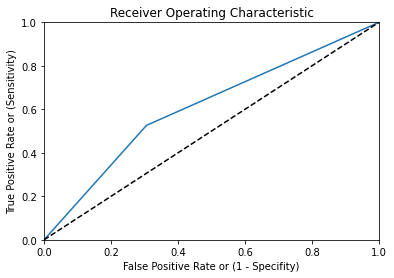

In [ ]:
## B
model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='lbfgs') 
model = model.fit(train_word_average_b, y_train_w2v_b)
y_pred = model.predict(test_word_average_b)

lb = LabelEncoder()
y_pred = lb.fit_transform(y_pred)
y_val_w2v = lb.fit_transform(y_val_w2v_b)

evaluate_on_training_set(y_val_w2v, y_pred)

In [ ]:
## C
X_train_w2v_c, X_val_w2v_c, y_train_w2v_c, y_val_w2v_c = train_test_split(c_trainX_w2v, c_trainY_w2v, test_size = 0.1,
                                                        random_state = 37)
train_word_average_c = word_averaging_list(w2v, X_train_w2v_c)
test_word_average_c = word_averaging_list(w2v, X_val_w2v_c)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


AUC is:  0.6000184147798913
              precision    recall  f1-score   support

           0       0.36      0.54      0.43        97
           1       0.80      0.39      0.53       261
           2       0.12      0.47      0.19        30

    accuracy                           0.44       388
   macro avg       0.43      0.47      0.38       388
weighted avg       0.64      0.44      0.48       388

Confusion Matrix: 
 [[ 52  17  28]
 [ 83 103  75]
 [  8   8  14]]


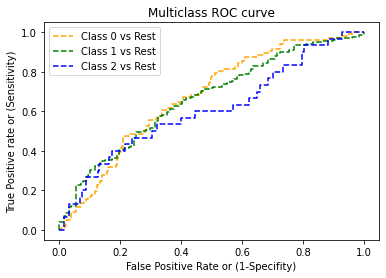

In [ ]:
## C
model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='lbfgs') 
model = model.fit(train_word_average_c, y_train_w2v_c)
y_pred = model.predict(test_word_average_c)
y_pred_prob = model.predict_proba(test_word_average_c)

lb = LabelEncoder()
y_pred = lb.fit_transform(y_pred)
y_val_w2v = lb.fit_transform(y_val_w2v_c)

evaluate_on_training_set_multi(y_val_w2v, y_pred, y_pred_prob)

## Logistic Regression using GloVe

In [ ]:
a_trainX_em, a_testX_em, a_trainY_em, a_testY_em = train_test_split(a_trainX_em, le_a_trainY_df, test_size=0.1, random_state=37)

AUC is:  0.6112068965517241
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       812
           1       0.44      0.55      0.49       380

    accuracy                           0.63      1192
   macro avg       0.60      0.61      0.60      1192
weighted avg       0.66      0.63      0.64      1192

Confusion Matrix: 
 [[546 266]
 [171 209]]


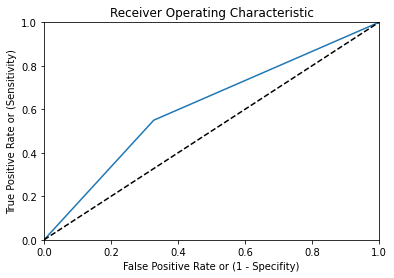

In [ ]:
model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='lbfgs')
model.fit(a_trainX_em, a_trainY_em)

y_pred = model.predict(a_testX_em)

evaluate_on_training_set(a_testY_em, y_pred)

In [ ]:
b_trainX_em, b_testX_em, b_trainY_em, b_testY_em = train_test_split(b_trainX_em, le_b_trainY_df, test_size=0.1, random_state=37)

AUC is:  0.5874534161490683
              precision    recall  f1-score   support

           0       0.91      0.63      0.75       350
           1       0.16      0.54      0.25        46

    accuracy                           0.62       396
   macro avg       0.54      0.59      0.50       396
weighted avg       0.83      0.62      0.69       396

Confusion Matrix: 
 [[221 129]
 [ 21  25]]


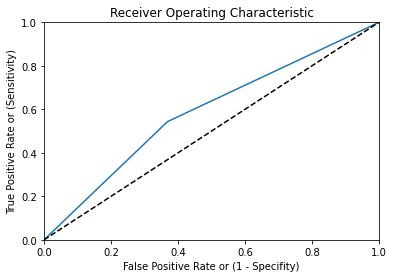

In [ ]:
model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='lbfgs')
model.fit(b_trainX_em, b_trainY_em)

y_pred = model.predict(b_testX_em)

evaluate_on_training_set(b_testY_em, y_pred)

In [ ]:
c_trainX_em, c_testX_em, c_trainY_em, c_testY_em = train_test_split(c_trainX_em, le_c_trainY_df, test_size=0.1, random_state=37)

AUC is:  0.5549281017582403
              precision    recall  f1-score   support

           0       0.35      0.35      0.35       102
           1       0.68      0.47      0.56       214
           2       0.13      0.39      0.20        33

    accuracy                           0.43       349
   macro avg       0.39      0.41      0.37       349
weighted avg       0.53      0.43      0.46       349

Confusion Matrix: 
 [[ 36  37  29]
 [ 58 101  55]
 [ 10  10  13]]


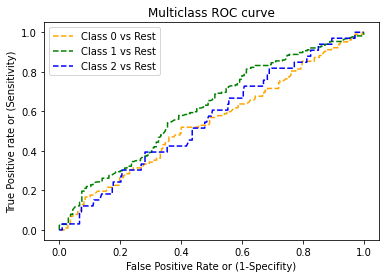

In [ ]:
model = LogisticRegression(max_iter=100000, class_weight='balanced', solver='lbfgs')
model.fit(c_trainX_em, c_trainY_em)

y_pred = model.predict(c_testX_em)
y_pred_prob = model.predict_proba(c_testX_em)

evaluate_on_training_set_multi(c_testY_em, y_pred, y_pred_prob)

## Based on the above results, GloVe gives us the most optimal results for Macro F1 and Recall Score. We will proceed with GloVe for the rest of the models.

##Try for weather

In [ ]:

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding
from keras import Input
from keras import models
from keras import layers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, SpatialDropout1D, Bidirectional, GlobalMaxPool1D
from tensorflow.keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.preprocessing import sequence
from numpy.random import seed

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import keras
import sklearn.metrics as metrics

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

import tensorflow as tf

In [ ]:
#vec_trainX_df, vec_testX_df, word_index, em_mat
#vec_trainX_df.shape

len(word_index)
len(em_mat)

11107

In [ ]:
#The settings we are using 
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = em_mat.shape[1]
word_index = em_mat.shape[0]

In [ ]:
embedding_layer = Embedding((word_index),
                            EMBEDDING_DIM,
                            weights=[em_mat],
                            input_length=MAX_SEQUENCE_LENGTH, 
                            trainable = False)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# One-hot encoding
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(trainY_df)

trainY_df_oh = encoder.transform(trainY_df)
trainY_df_oh= np_utils.to_categorical(trainY_df_oh)
print(trainY_df_oh)

LabelEncoder()

In [ ]:
trainY_df_oh.shape, vec_trainX_df.shape

((22500, 3), (22500, 25))

In [ ]:
model_nn1 = Sequential()
model_nn1.add(embedding_layer)
model_nn1.add(Conv1D(100, 2, activation='relu')) #filters, kernel size
model_nn1.add(Dropout(0.2))
model_nn1.add(Conv1D(100, 3, activation='relu'))
model_nn1.add(Dropout(0.2))
model_nn1.add(MaxPooling1D(3))
model_nn1.add(Dropout(0.5))
model_nn1.add(Bidirectional(LSTM(128,dropout = 0.5)))
model_nn1.add(Dense(3))
model_nn1.add(Activation('softmax'))
model_nn1.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [ ]:
tf.random.set_seed(123)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 15, verbose = 1,restore_best_weights = True, mode = 'min')
model_checkpoint = ModelCheckpoint('best_model_c2', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
history = model_nn1.fit(vec_trainX_df,trainY_df_oh, epochs=30, verbose = 1, validation_split= 0.2 ,callbacks = [earlystop,model_checkpoint])

Epoch 1/30
562/563 [============================>.] - ETA: 0s - loss: 0.1944 - accuracy: 0.9300
Epoch 00001: val_loss improved from inf to 0.33830, saving model to best_model_c2
INFO:tensorflow:Assets written to: best_model_c2/assets
563/563 [==============================] - 15s 27ms/step - loss: 0.1943 - accuracy: 0.9301 - val_loss: 0.3383 - val_accuracy: 0.8833
Epoch 2/30
563/563 [==============================] - ETA: 0s - loss: 0.2385 - accuracy: 0.9107
Epoch 00002: val_loss improved from 0.33830 to 0.32641, saving model to best_model_c2
INFO:tensorflow:Assets written to: best_model_c2/assets
563/563 [==============================] - 15s 26ms/step - loss: 0.2385 - accuracy: 0.9107 - val_loss: 0.3264 - val_accuracy: 0.8793
Epoch 3/30
562/563 [============================>.] - ETA: 0s - loss: 0.2977 - accuracy: 0.8850
Epoch 00003: val_loss did not improve from 0.32641
563/563 [==============================] - 4s 7ms/step - loss: 0.2975 - accuracy: 0.8850 - val_loss: 0.3264 - val_a

In [ ]:
saved_model_weather = load_model('best_model_c2')

In [ ]:
predicted_sentiment = saved_model_weather.predict(vec_testX_df)

In [ ]:
predicted_sentiment

array([[0.34830293, 0.24814071, 0.40355638],
       [0.54623413, 0.32551613, 0.12824973],
       [0.20750608, 0.00857088, 0.78392303],
       ...,
       [0.02563802, 0.97010416, 0.00425781],
       [0.02359507, 0.00448107, 0.9719239 ],
       [0.99135417, 0.00164422, 0.00700157]], dtype=float32)

In [ ]:
predicted_sentiment= saved_model_weather.predict_classes(vec_testX_df)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
pd.DataFrame(predicted_sentiment).to_csv("submission4.csv")
#df.to_csv('data.csv')